## Measuring the value of controlled pitch

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patheffects as path_effects
from scipy.spatial import ConvexHull
from scipy.spatial import Voronoi

from shapely.ops import cascaded_union
from shapely.geometry import Polygon, MultiPoint
from shapely import affinity

%matplotlib inline

# Loading Data

In [2]:
#df = pd.read_csv('../datasets/BRA_0-[5]_GER_positional_data.csv', index_col=(0,1))
#dfPlayers = pd.read_csv('../datasets/BRA_0-[5]_GER_player_data.csv', index_col=0)

play = '../datasets/BRA_0-[5]_GER'

df = pd.read_csv(play+'_positional_data.csv', index_col=(0,1))
dfPlayers = pd.read_csv(play+'_player_data.csv', index_col=0)

dfPlayers

,coords,player_num,player_obj,team,num,name,edgecolor,bgcolor
player,,,,,,,,
12,"(390.82329814922076, 230.3681266177904)",5.0,12,attack,NaN,NaN,red,black
1923,"(192.70181613677647, 287.0911467596564)",6.0,1923,attack,NaN,NaN,red,black
3235,"(187.2173482005435, 323.5288842347714)",8.0,3235,attack,NaN,NaN,red,black
6439,"(218.60259895696848, 226.14081165461812)",NaN,6439,attack,NaN,NaN,red,black
7600,"(174.46875, 274.625)",NaN,7600,defense,NaN,NaN,blue,yellow
14761,"(215.71575859162712, 215.28004377345493)",NaN,14761,defense,NaN,NaN,blue,yellow
16656,"(202.12091085738695, 337.46147632768816)",NaN,16656,defense,NaN,NaN,blue,yellow
18912,"(190.5326064508669, 132.68650155862397)",NaN,18912,defense,NaN,NaN,blue,yellow
21118,"(236.0, 151.0)",NaN,21118,defense,NaN,NaN,blue,yellow


# Drawing the basic pitch

In [3]:
X_SIZE = 105.0
Y_SIZE = 68.0

BOX_HEIGHT = (16.5*2 + 7.32)/Y_SIZE*100
BOX_WIDTH = 16.5/X_SIZE*100

GOAL = 7.32/Y_SIZE*100

GOAL_AREA_HEIGHT = 5.4864*2/Y_SIZE*100 + GOAL
GOAL_AREA_WIDTH = 5.4864/X_SIZE*100

SCALERS = np.array([X_SIZE/100, Y_SIZE/100])

def draw_pitch(dpi=100):
    """Sets up field
    Returns matplotlib fig and axes objects.
    """

    fig = plt.figure(figsize=(12.8, 7.2), dpi=dpi) #(X_SIZE/10, Y_SIZE/10)
    fig.patch.set_facecolor('#a8bc95') #complementary: #80a260 e #95bbbc, opposing: #bc95a8 & #bc9f95

    axes = fig.add_subplot(1, 1, 1)
    axes.set_axis_off()
    axes.set_facecolor('#a8bc95')
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)

    axes.set_xlim(0,100)
    axes.set_ylim(0,100)

    plt.xlim([-13.32, 113.32])
    plt.ylim([-5, 105])

    fig.tight_layout(pad=3)

    draw_patches(axes)

    return fig, axes

def draw_patches(axes):
    """
    Draws basic field shapes on an axes
    """
    #pitch
    axes.add_patch(plt.Rectangle((0, 0), 100, 100,
                       edgecolor="white", facecolor="none"))

    #half-way line
    axes.add_line(plt.Line2D([50, 50], [100, 0],
                    c='w'))

    #penalty areas
    axes.add_patch(plt.Rectangle((100-BOX_WIDTH, (100-BOX_HEIGHT)/2),  BOX_WIDTH, BOX_HEIGHT,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-BOX_HEIGHT)/2),  BOX_WIDTH, BOX_HEIGHT,
                               ec='w', fc='none'))

    #goal areas
    axes.add_patch(plt.Rectangle((100-GOAL_AREA_WIDTH, (100-GOAL_AREA_HEIGHT)/2),  GOAL_AREA_WIDTH, GOAL_AREA_HEIGHT,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-GOAL_AREA_HEIGHT)/2),  GOAL_AREA_WIDTH, GOAL_AREA_HEIGHT,
                               ec='w', fc='none'))

    #goals
    axes.add_patch(plt.Rectangle((100, (100-GOAL)/2),  1, GOAL,
                       ec='w', fc='none'))
    axes.add_patch(plt.Rectangle((0, (100-GOAL)/2),  -1, GOAL,
                               ec='w', fc='none'))


    #halfway circle
    axes.add_patch(Ellipse((50, 50), 2*9.15/X_SIZE*100, 2*9.15/Y_SIZE*100,
                                    ec='w', fc='none'))

    return axes

# Drawing Players and the Ball

In [4]:
def draw_frame(df, dfPlayers, t, text_color='black'):
    f = int(t*20)
    fig, ax = draw_pitch()
    dfFrame = df.loc[f]

    for pid in dfFrame.index:
        if pid==0:
            #formatting for ball (id==0)
            try:
                z = dfFrame.loc[pid]['z']
            except:
                z = 0
            size = 1.3+z
            lw = 0.7
            color='black'
            edge='white'
            zorder = 100
        else:
            #formatting for players
            size = 3
            lw = 2
            edge =  dfPlayers.loc[pid]['edgecolor']

            color = dfPlayers.loc[pid]['bgcolor']
            if dfPlayers.loc[pid]['team']=='attack':
                zorder = 21
            else:
                zorder = 20

        ax.add_artist(Ellipse((dfFrame.loc[pid]['x'],
                               dfFrame.loc[pid]['y']),
                              size/X_SIZE*100, size/Y_SIZE*100,
                              edgecolor=edge,
                              linewidth=lw,
                              facecolor=color,
                              alpha=0.8,
                              zorder=zorder))

        if pid!=0:
            s = dfPlayers.loc[pid]['player_num']
            if not(pd.isnull(s)):
                if isinstance(s, float):
                    s=int(s)
                text = plt.text(dfFrame.loc[pid]['x'],dfFrame.loc[pid]['y'],str(s),
                                horizontalalignment='center', verticalalignment='center',
                                fontsize=8, color=text_color, zorder=22, alpha=0.8)

                text.set_path_effects([path_effects.Stroke(linewidth=1, foreground=text_color, alpha=0.8),
                                       path_effects.Normal()])

    return fig, ax, dfFrame


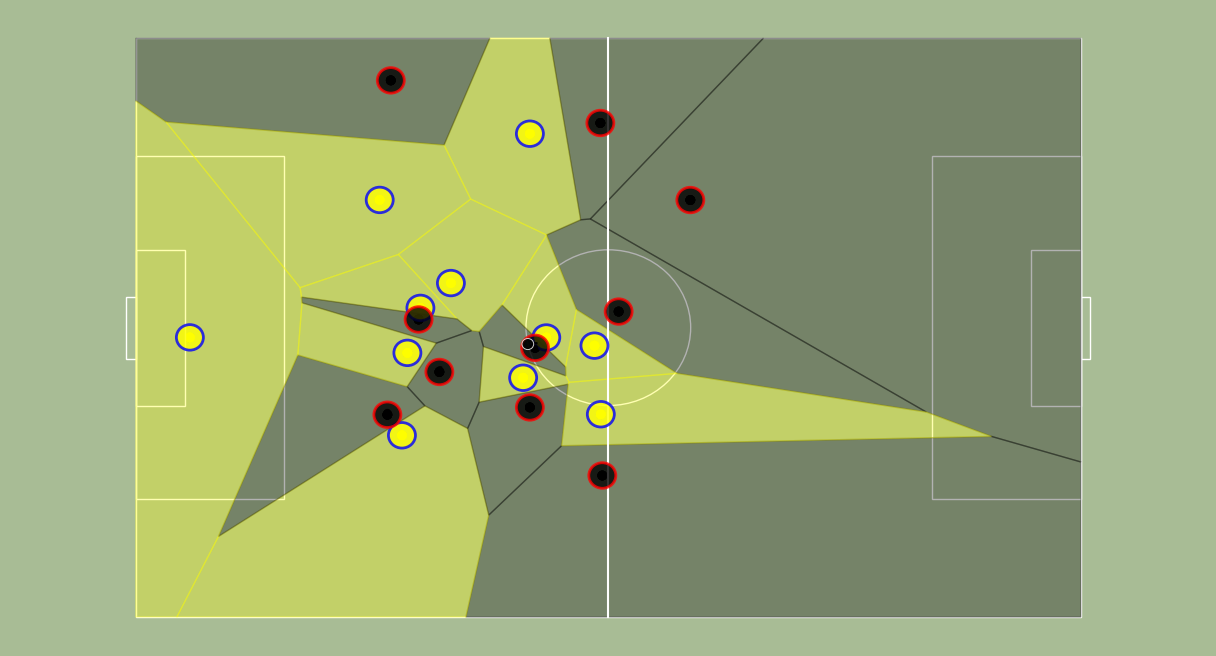

In [5]:
direction = -1

def calculate_voronoi(dfFrame, dfPlayers):
    dfTemp = dfFrame.copy().drop(0, errors='ignore').join(dfPlayers, rsuffix='_dup')

    values = np.vstack((dfTemp[['x', 'y']].values*SCALERS,
                        [-1000,-1000],
                        [+1000,+1000],
                        [+1000,-1000],
                        [-1000,+1000]
                       ))

    vor = Voronoi(values)

    dfTemp['region'] = vor.point_region[:-4]

    return vor, dfTemp

pitch = Polygon(((0,0), (0,100), (100,100), (100,0)))

def draw_voronoi(df, dfPlayers, t):
    fig, ax, dfFrame = draw_frame(df, dfPlayers, t)
    vor, dfVor = calculate_voronoi(dfFrame, dfPlayers)
    polygons = {}
    for index, region in enumerate(vor.regions):
        if not -1 in region:
            if len(region)>0:
                try:
                    pl = dfVor[dfVor['region']==index]
                    polygon = Polygon([vor.vertices[i] for i in region]/SCALERS).intersection(pitch)
                    color = pl['bgcolor'].values[0]
                    x, y = polygon.exterior.xy
                    plt.fill(x, y, c=color, alpha=0.30)
                    polygons[pl.index[0]] = polygon
                except IndexError:
                    pass
                except AttributeError:
                    pass

        plt.scatter(dfVor['x'], dfVor['y'], c=dfVor['bgcolor'], alpha=0.2)
    return fig, ax, dfFrame, polygons


fig, ax, dfFrame, polygons = draw_voronoi(df, dfPlayers, t=2.5)


# Pitch value

In [6]:
import json
with open('../datasets/open_xt_12x8_v1.json', 'r') as f:
    xTvalues = np.array(json.load(f))
    
def offset_df(df, dx, dy):
    df = df.copy()
    df.x = df.x+dx
    df.y = df.y+dy  
    return df

dfxT = df.from_records(xTvalues).unstack().reset_index()
dfxT.columns = ['x', 'y', 'xT']

dfxT = pd.concat([offset_df(dfxT, dx, dy)
                  for dx, dy
                  in [(0.25, 0.25), (0.25, 0.75), (0.75, 0.25), (0.75, 0.75)]
                 ])

ny, nx = xTvalues.shape

dfxT.x = dfxT.x*100/nx
dfxT.y = dfxT.y*100/ny

#only consider locations with better than median threat (i.e. ignore defensive positions)
dfxT.xT = np.clip(dfxT.xT-dfxT.xT.median(), 0, 1)

#flip axis (align with attacking team)
dfxT.x = 100-dfxT.x
dfxT.y = 100-dfxT.y

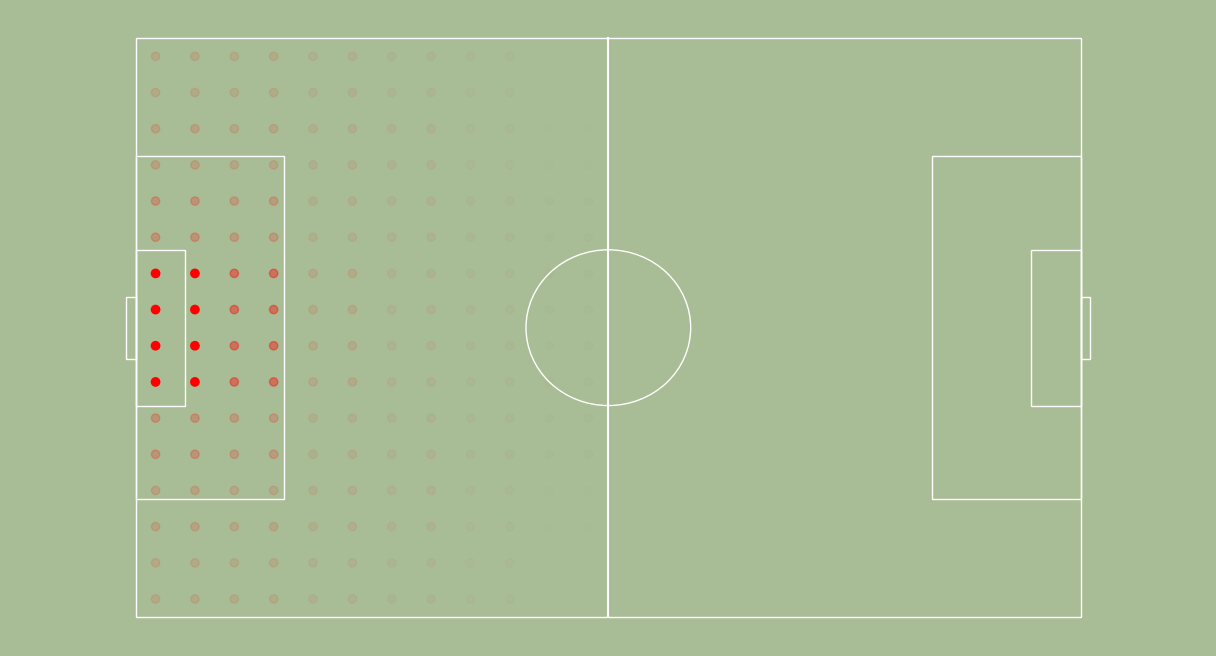

In [7]:
import itertools

fig, ax = draw_pitch()

#plotting pitch with probability
rgba_colors = np.zeros((dfxT.shape[0],4))
rgba_colors[:,0] = 1.0
rgba_colors[:,3] = dfxT.xT.values/dfxT.xT.max()
plt.scatter(dfxT['x'], dfxT['y'], c=rgba_colors)

In [8]:
points = MultiPoint(list(zip(dfxT['x'], dfxT['y'])))
dfValues = dfxT.set_index(['x', 'y'])

In [9]:
%%timeit
player_values = {}

attack_polygon = cascaded_union([polygon for player,polygon in polygons.items() if dfPlayers.loc[player]['team']=='attack'])

values = [dfValues.loc[p.x,p.y].values[0] for p in attack_polygon.intersection(points)]
area_value = np.mean(values)*attack_polygon.area

156 ms ± 6.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
def calculate_value(df, dfPlayers, t):
    f = int(t*20)
    dfFrame = df.loc[f]
    vor, dfVor = calculate_voronoi(dfFrame, dfPlayers)
    polygons = {}
    for index, region in enumerate(vor.regions):
        if not -1 in region:
            if len(region)>0:
                try:
                    pl = dfVor[dfVor['region']==index]
                    polygon = Polygon([vor.vertices[i] for i in region]/SCALERS).intersection(pitch)
                    polygons[pl.index[0]] = polygon
                except IndexError:
                    pass
                except AttributeError:
                    pass
    
    attack_polygon = cascaded_union([polygon for player,polygon in polygons.items() if dfPlayers.loc[player]['team']=='attack'])
    values = [dfValues.loc[p.x,p.y].values[0] for p in attack_polygon.intersection(points)]
    area_value = np.mean(values)*attack_polygon.area
    return area_value

values = [calculate_value(df, dfPlayers, t=t/10) for t in range(int(max(df.index)[0]/20*10))]

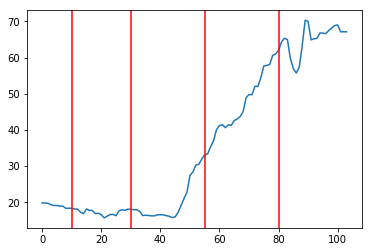

In [11]:
plt.plot(values)

highlights = [1, 3, 5.5, 8]

for h in highlights:
    plt.axvline(h*10, c='red')

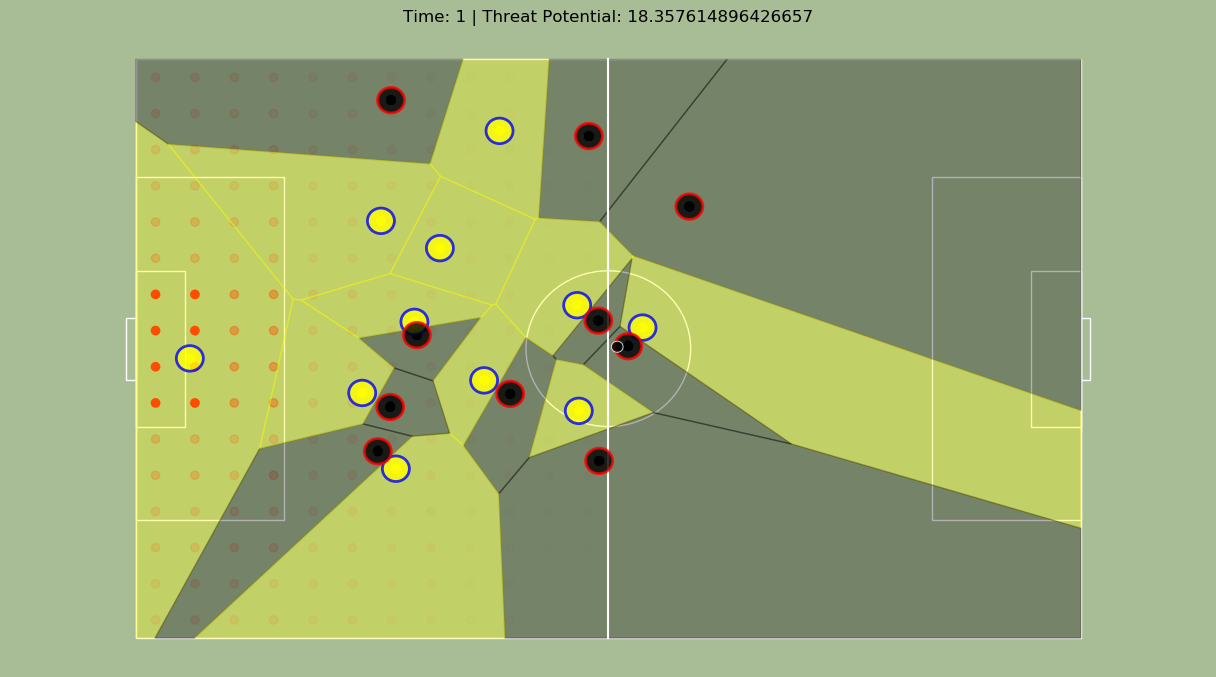

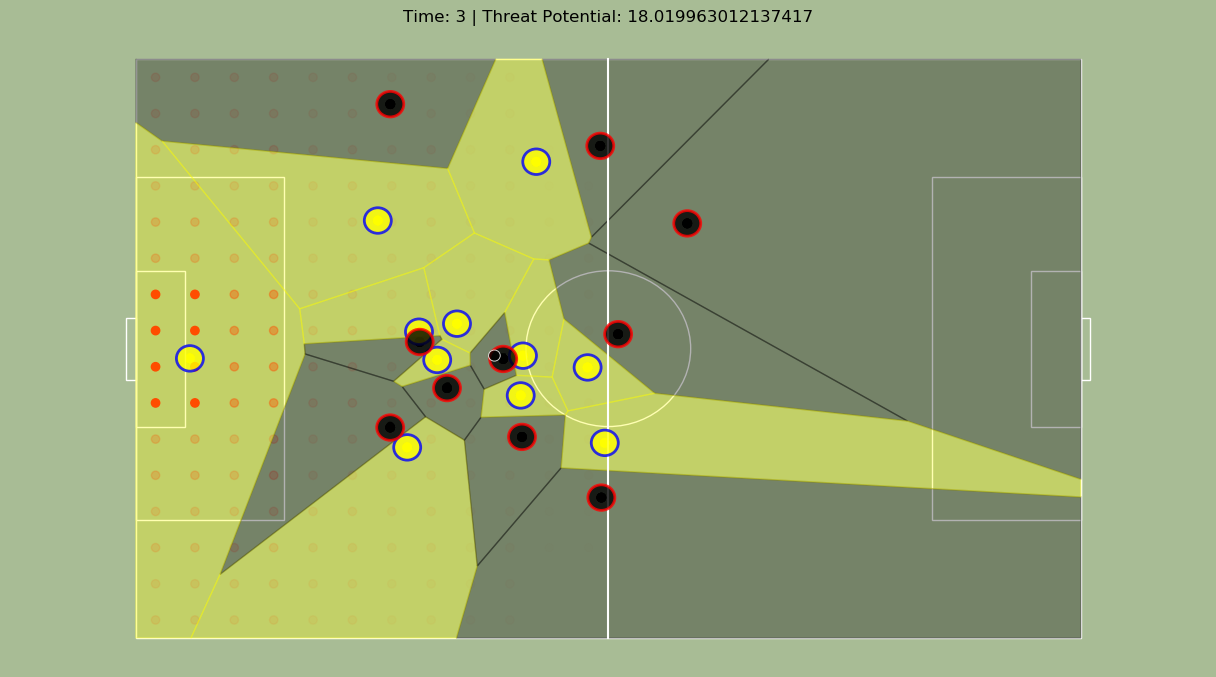

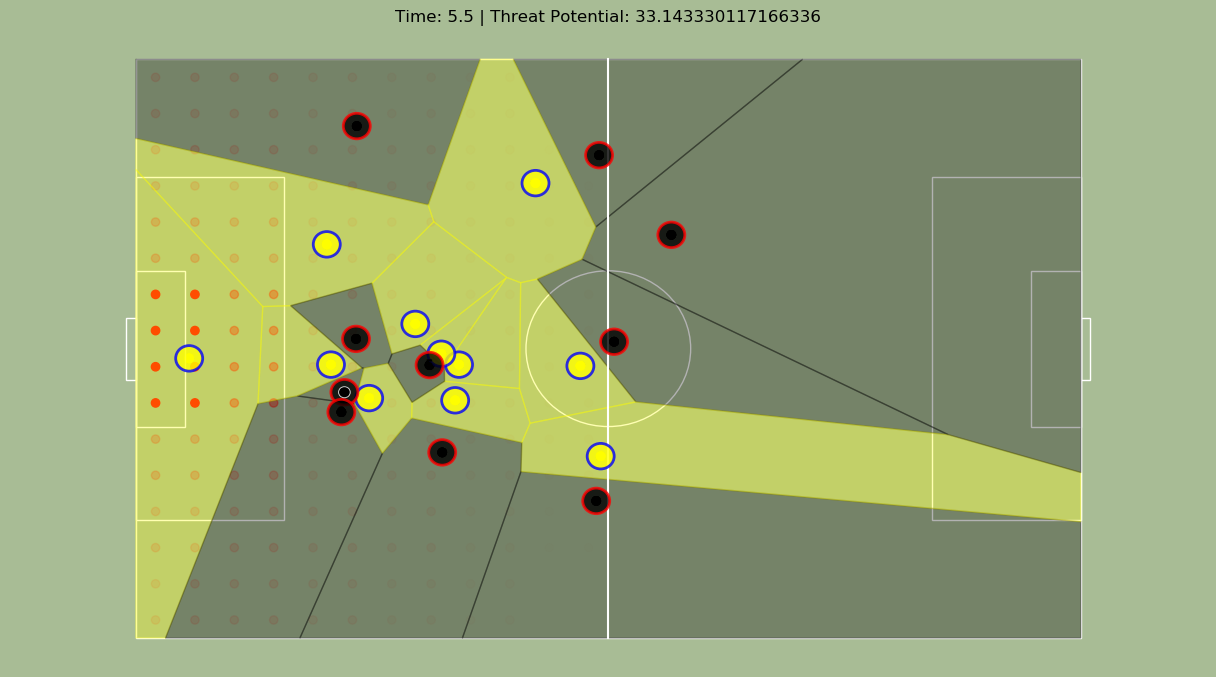

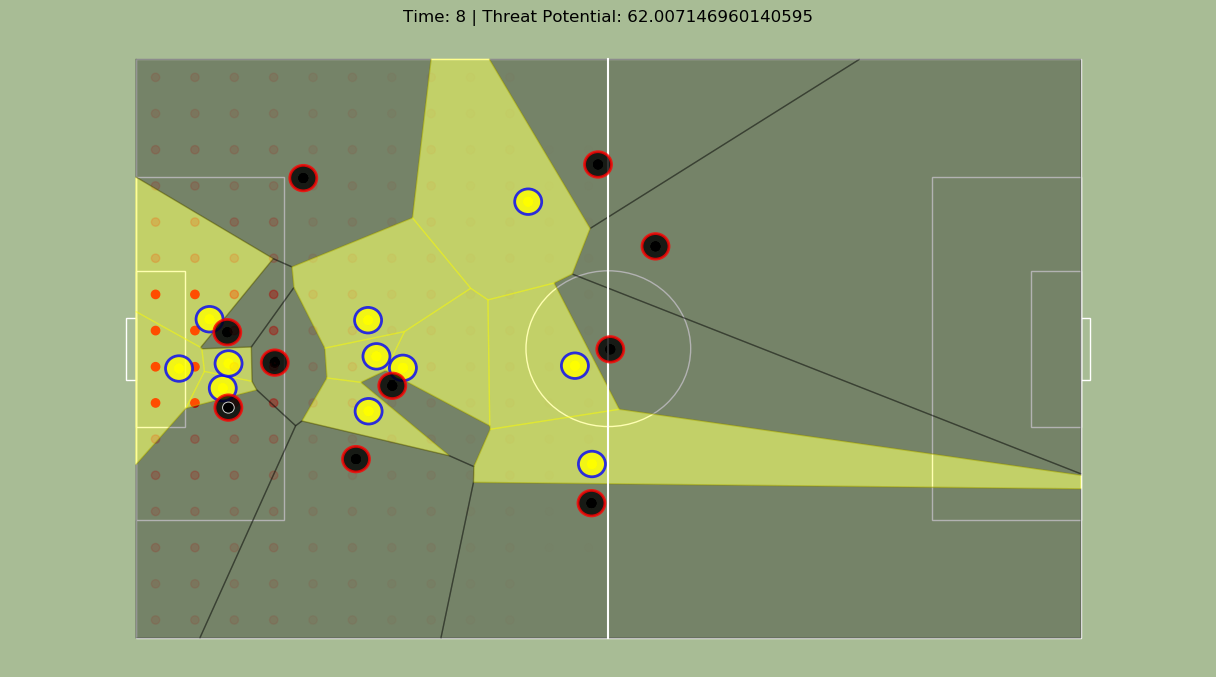

In [12]:
for h in highlights:
    draw_voronoi(df, dfPlayers, h)
    plt.title('Time: {} | Threat Potential: {}'.format(h, values[int(h*10)]))
    plt.scatter(dfxT['x'], dfxT['y'], c=rgba_colors)